This script calculates predefined audio features, spectrograms and cepstral coefficients from audio data and exports them to a csv.

In [220]:
import glob
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import seaborn as sns
import random
from scipy.stats import kurtosis, skew
import parselmouth
from skimage.transform import resize
import json
from scipy.fftpack import dct

In [221]:
random.seed(42)

In [222]:
DATAPATH = "/Users/lenagies/Desktop/Master/Thesis/geese/data/clips_from_selections"
clip_paths = glob.glob(DATAPATH+"/*.wav")

In [223]:
len(clip_paths)

7553

##### Inspect single call

In [224]:
i = 1450
n_fft = 512
hop_overlap = 9
top_db_silence = 40

In [225]:
vocalization, sr = librosa.load(clip_paths[i], sr=None)

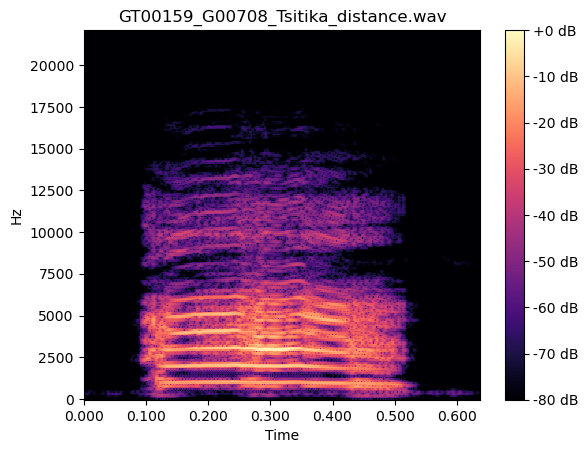

In [226]:
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(vocalization, n_fft=n_fft, hop_length=(n_fft//hop_overlap))), ref=np.max), sr=sr, hop_length=(n_fft//hop_overlap), x_axis='time', y_axis='linear', ax=ax)
ax.set(title=clip_paths[i].split("/")[-1])
fig.colorbar(img, ax=ax, format="%+2.f dB")

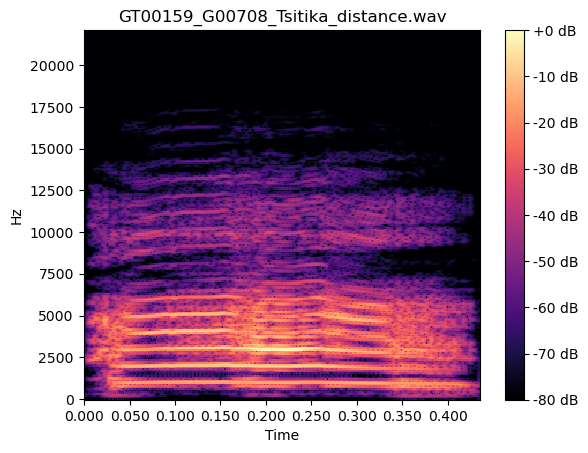

In [227]:
# trim trailing silences using db threshold, discard second entry, that holds indices
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(librosa.effects.trim(vocalization, top_db=top_db_silence, frame_length=n_fft, hop_length=(n_fft//hop_overlap))[0], n_fft=n_fft, hop_length=(n_fft//hop_overlap))), ref=np.max), sr=sr, hop_length=(n_fft//hop_overlap), x_axis='time', y_axis='linear', ax=ax)
ax.set(title=clip_paths[i].split("/")[-1])
fig.colorbar(img, ax=ax, format="%+2.f dB")

min max normalization: 
$X = \frac{X - X_{min}}{X_{max} - X_{min}}$

##### Process clips and write to dataframe
- trim
- normalize 

Read sound files into dataframe and preprocess inside loop:
- Trim silences
- Normalize (peak)

In [228]:
# LFCCs: adapted from Heinrich Dinkel: https://gist.github.com/RicherMans/dc1b50dd8043cee5872e0b7584f6202f, gitHub profile: https://github.com/RicherMans
def _lin_filter_bank(sr, n_fft, n_filter=128, fmin=0.0, fmax=None, dtype=np.float32):
    # linear filter bank
    if fmax is None:
        fmax = float(sr) / 2
    # Initialize the weights
    n_filter = int(n_filter)
    weights = np.zeros((n_filter, int(1 + n_fft // 2)), dtype=dtype)

    # Center freqs of each FFT bin
    fftfreqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

    # 'Center freqs' of liner bands - uniformly spaced between limits
    linear_f = np.linspace(fmin, fmax, n_filter + 2)

    fdiff = np.diff(linear_f)
    ramps = np.subtract.outer(linear_f, fftfreqs)

    for i in range(n_filter):
        # lower and upper slopes for all bins
        lower = -ramps[i] / fdiff[i]
        upper = ramps[i + 2] / fdiff[i + 1]

        # .. then intersect them with each other and zero
        weights[i] = np.maximum(0, np.minimum(lower, upper))

    return weights

In [229]:
def _min_max_scale(waveform):
    # Normalizes Spectrogram to values between 0 and 1
    return (waveform - waveform.min()) / (waveform.max() - waveform.min())
    
def _peak_normalization(waveform):
    # from biosound package: https://github.com/theunissenlab/BioSoundTutorial/blob/master/BioSound1.ipynb
    return np.array((waveform / np.max(np.abs(waveform))), np.float32)

def _to_pixel_and_cut(spectrogram):
    spectrogram = _min_max_scale(spectrogram) # transform to pixel values
    #spectrogram = spectrogram[::3, ::3] # reduce to a third of the size
    return spectrogram[:int(len(spectrogram)*0.7), :] # cut out higher frequencies where no power is left

def _lin_spectrogram(waveform, plot=False):
    spectrogram = np.abs(librosa.stft(waveform, n_fft=n_fft, hop_length=(n_fft//hop_overlap)))**2
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    if plot:
        fig, ax = plt.subplots()
        ax.matshow(_to_pixel_and_cut(spectrogram), origin="lower", cmap="magma")
        ax.axis("off")
        ax.set(title=clip_paths[i].split("/")[-1])
    return spectrogram

def _lfccs(waveform, sr, n_fft, dct_type=2, norm='ortho', plot=False, **kwargs):
    n_lfcc = len(waveform) // 300 # choose number of coefficients relative to call length
    spectrogram = np.abs(librosa.stft(waveform, n_fft=n_fft, hop_length=(n_fft//hop_overlap)))**2
    filter = _lin_filter_bank(sr=sr, n_fft=n_fft, **kwargs)
    filtered_S = np.dot(filter, spectrogram)
    filtered_S = librosa.power_to_db(filtered_S, ref=np.max)
    lfccs = dct(filtered_S, axis=0, type=dct_type, norm=norm)[:n_lfcc]
    if plot:
        fig, ax = plt.subplots()
        ax.matshow(_to_pixel_and_cut(lfccs), origin="lower", cmap="magma")
        ax.axis("off")
        ax.set(title=clip_paths[i].split("/")[-1])
    return lfccs

def _process_waveform(waveform):
    trimmed_waveform = librosa.effects.trim(waveform, top_db=top_db_silence, frame_length=n_fft, hop_length=(n_fft//hop_overlap))[0]
    normalized_waveform = _peak_normalization(trimmed_waveform)
    return normalized_waveform

(64, 344)

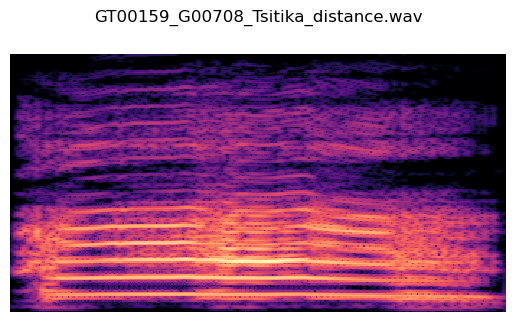

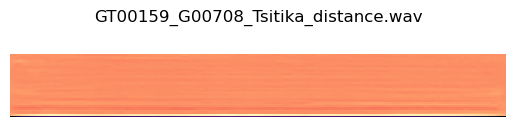

In [230]:
_lin_spectrogram(_process_waveform(vocalization), plot=True)
_lfccs(_process_waveform(vocalization), sr=sr, n_fft=n_fft, plot=True).shape

In [231]:
calls_df = pd.DataFrame(columns=["track_ID", "clip_ID", "goose_ID", "call_type", "waveform", "sr", "filepath", "spectrogram", "lfccs"])
for clip_path in tqdm(clip_paths):
    waveform, sr = librosa.load(clip_path, sr=None)
    waveform = _process_waveform(waveform) # trim silence and peak normalize
    if np.isnan(waveform).any():
        print(clip_path+" contains na")
        continue
    spectrogram = _lin_spectrogram(waveform) # transform to power spectrogram, min-max-scale, cut off higer frequencies
    lfccs = _lfccs(waveform, sr=sr, n_fft=n_fft)
    filename = clip_path.split("/")[-1].split(".")[0]
    calls_df.loc[len(calls_df)] = [filename.split("_")[0], filename.split("_")[1], filename.split("_")[2], filename.split("_")[3], waveform, sr, clip_path, spectrogram, lfccs]

  8%|▊         | 642/7553 [00:05<00:55, 125.13it/s]/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_6536/958721429.py:7: RuntimeWarning: invalid value encountered in divide
  return np.array((waveform / np.max(np.abs(waveform))), np.float32)
  9%|▉         | 674/7553 [00:05<00:49, 138.70it/s]

/Users/lenagies/Desktop/Master/Thesis/geese/data/clips_from_selections/GT00989_G14229_unknown_alarm.wav contains na


 31%|███       | 2322/7553 [00:19<00:51, 102.41it/s]/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_6536/958721429.py:7: RuntimeWarning: invalid value encountered in divide
  return np.array((waveform / np.max(np.abs(waveform))), np.float32)
 31%|███       | 2347/7553 [00:19<00:47, 110.59it/s]

/Users/lenagies/Desktop/Master/Thesis/geese/data/clips_from_selections/GT00984_G12616_Kruemmel_unknown.wav contains na


 32%|███▏      | 2414/7553 [00:20<00:53, 95.41it/s] /var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_6536/958721429.py:7: RuntimeWarning: invalid value encountered in divide
  return np.array((waveform / np.max(np.abs(waveform))), np.float32)
 32%|███▏      | 2435/7553 [00:20<00:53, 95.30it/s]

/Users/lenagies/Desktop/Master/Thesis/geese/data/clips_from_selections/GT00984_G12682_Bregenz_triumph.wav contains na


 32%|███▏      | 2448/7553 [00:20<00:48, 104.60it/s]/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_6536/958721429.py:7: RuntimeWarning: invalid value encountered in divide
  return np.array((waveform / np.max(np.abs(waveform))), np.float32)
 33%|███▎      | 2474/7553 [00:20<00:44, 114.08it/s]

/Users/lenagies/Desktop/Master/Thesis/geese/data/clips_from_selections/GT00984_G12619_Kruemmel_unknown.wav contains na


 44%|████▍     | 3319/7553 [00:28<00:41, 101.73it/s]/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_6536/958721429.py:7: RuntimeWarning: invalid value encountered in divide
  return np.array((waveform / np.max(np.abs(waveform))), np.float32)
 44%|████▍     | 3344/7553 [00:28<00:38, 108.01it/s]

/Users/lenagies/Desktop/Master/Thesis/geese/data/clips_from_selections/GT00984_G12633_Kruemmel_unknown.wav contains na


 67%|██████▋   | 5080/7553 [00:46<00:27, 89.53it/s] /var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_6536/958721429.py:7: RuntimeWarning: invalid value encountered in divide
  return np.array((waveform / np.max(np.abs(waveform))), np.float32)
 68%|██████▊   | 5100/7553 [00:46<00:26, 91.25it/s]

/Users/lenagies/Desktop/Master/Thesis/geese/data/clips_from_selections/GT00984_G12622_Kruemmel_unknown.wav contains na


 71%|███████   | 5344/7553 [00:49<00:23, 92.50it/s]/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_6536/958721429.py:7: RuntimeWarning: invalid value encountered in divide
  return np.array((waveform / np.max(np.abs(waveform))), np.float32)
 71%|███████   | 5367/7553 [00:49<00:21, 100.98it/s]

/Users/lenagies/Desktop/Master/Thesis/geese/data/clips_from_selections/GT00984_G12615_Kruemmel_unknown.wav contains na


 76%|███████▌  | 5721/7553 [00:53<00:19, 94.02it/s] /var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_6536/958721429.py:7: RuntimeWarning: invalid value encountered in divide
  return np.array((waveform / np.max(np.abs(waveform))), np.float32)
 76%|███████▌  | 5741/7553 [00:53<00:19, 91.67it/s]

/Users/lenagies/Desktop/Master/Thesis/geese/data/clips_from_selections/GT00984_G12631_Kruemmel_unknown.wav contains na


 87%|████████▋ | 6577/7553 [01:02<00:10, 96.83it/s] /var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_6536/958721429.py:7: RuntimeWarning: invalid value encountered in divide
  return np.array((waveform / np.max(np.abs(waveform))), np.float32)
 87%|████████▋ | 6597/7553 [01:02<00:10, 89.10it/s]

/Users/lenagies/Desktop/Master/Thesis/geese/data/clips_from_selections/GT00984_G12602_Kruemmel_triumph.wav contains na


 87%|████████▋ | 6606/7553 [01:02<00:10, 88.84it/s]/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_6536/958721429.py:7: RuntimeWarning: invalid value encountered in divide
  return np.array((waveform / np.max(np.abs(waveform))), np.float32)
 88%|████████▊ | 6625/7553 [01:03<00:10, 85.89it/s]

/Users/lenagies/Desktop/Master/Thesis/geese/data/clips_from_selections/GT00984_G12763_Bregenz_unknown.wav contains na


100%|██████████| 7553/7553 [01:14<00:00, 100.88it/s]


In [232]:
len(calls_df)

7543

In [233]:
calls_df.head()

,track_ID,clip_ID,goose_ID,call_type,waveform,sr,filepath,spectrogram,lfccs
0,GT00780,G11666,Lando,recruitment,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[-80.0, -80.0, -80.0, -74.5504, -68.28476, -6...","[[-885.8393, -862.04083, -834.7281, -813.42786..."
1,GT00772,G11510,Burglar,recruitment,"[0.0016997167, 0.0056657223, 0.007082153, 0.00...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[-58.680573, -59.456085, -62.740047, -69.3654...","[[-830.7733, -819.18225, -810.61523, -803.8673..."
2,GT00795,G11994,EinStein,contact,"[-0.0010507881, -0.0017513135, -0.0017513135, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...","[[-841.1946, -834.2097, -831.37274, -829.4686,..."
3,GT00447,G04128,BruceSpringsteen,departure,"[-0.00035599858, -0.00071199716, -0.0007119971...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...","[[-863.0115, -852.62213, -838.2617, -811.85333..."
4,GT00775,G11567,Anthony,recruitment,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[-72.21927, -68.95039, -69.03602, -73.3953, -...","[[-869.5825, -851.7381, -835.519, -821.2745, -..."


/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_6536/1510808998.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  hist = sns.histplot(


[]

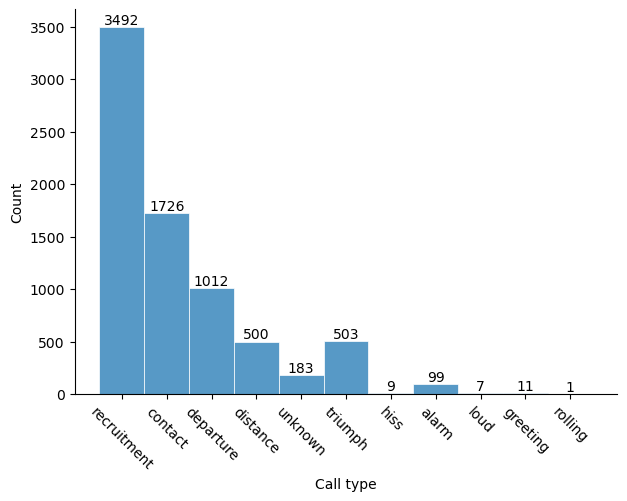

In [234]:
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)

hist = sns.histplot(
    calls_df,
    x="call_type",
    multiple="stack",
    palette="viridis",
    edgecolor="1",
    linewidth=.5,
)

plt.xticks(rotation=-45)
ax.set_xlabel("Call type")

# Add counts
for p in hist.patches:
    height = p.get_height()
    x = p.get_x() + p.get_width() / 2
    ax.annotate(f'{int(height)}', (x, height), ha='center', va='bottom')
    
plt.plot()

Discard vocalizations labelled as hisses, loud, greeting and rolling calls and only keep random subset of recruitment, departure and contact calls to balance the representations of the different classes. These labels are not used in the current protocol (and we have too few hisses).

In [235]:
# discard loud, greeting and rolling calls
calls_df = calls_df[~calls_df['call_type'].isin(['loud', 'greeting', 'rolling', 'hiss'])]

/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_6536/1510808998.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  hist = sns.histplot(


[]

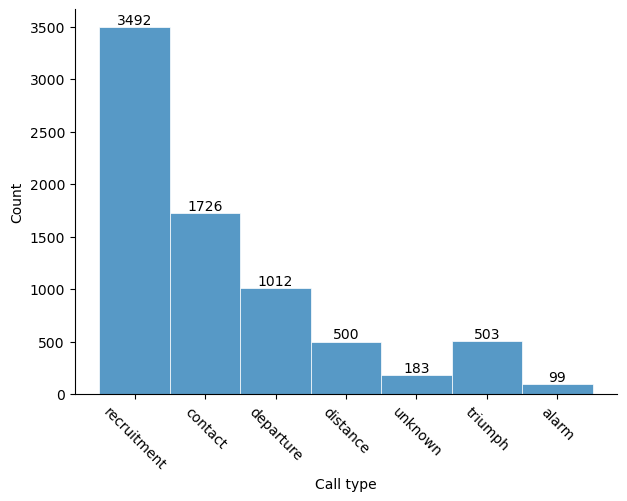

In [236]:
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)

hist = sns.histplot(
    calls_df,
    x="call_type",
    multiple="stack",
    palette="viridis",
    edgecolor="1",
    linewidth=.5,
)

plt.xticks(rotation=-45)
ax.set_xlabel("Call type")

# Add counts
for p in hist.patches:
    height = p.get_height()
    x = p.get_x() + p.get_width() / 2
    ax.annotate(f'{int(height)}', (x, height), ha='center', va='bottom')
    
plt.plot()

Plot the durations of the calls

In [237]:
calls_df['duration'] = calls_df.apply(lambda row: len(row['waveform']) / row['sr'], axis=1)
calls_df['log_duration'] = calls_df.apply(lambda row: np.log(row['duration']), axis=1)
calls_df.head()

,track_ID,clip_ID,goose_ID,call_type,waveform,sr,filepath,spectrogram,lfccs,duration,log_duration
0,GT00780,G11666,Lando,recruitment,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[-80.0, -80.0, -80.0, -74.5504, -68.28476, -6...","[[-885.8393, -862.04083, -834.7281, -813.42786...",0.105397,-2.250023
1,GT00772,G11510,Burglar,recruitment,"[0.0016997167, 0.0056657223, 0.007082153, 0.00...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[-58.680573, -59.456085, -62.740047, -69.3654...","[[-830.7733, -819.18225, -810.61523, -803.8673...",0.104807,-2.255632
2,GT00795,G11994,EinStein,contact,"[-0.0010507881, -0.0017513135, -0.0017513135, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...","[[-841.1946, -834.2097, -831.37274, -829.4686,...",0.104127,-2.262144
3,GT00447,G04128,BruceSpringsteen,departure,"[-0.00035599858, -0.00071199716, -0.0007119971...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...","[[-863.0115, -852.62213, -838.2617, -811.85333...",0.162925,-1.814464
4,GT00775,G11567,Anthony,recruitment,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[-72.21927, -68.95039, -69.03602, -73.3953, -...","[[-869.5825, -851.7381, -835.519, -821.2745, -...",0.093968,-2.364798


/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_6536/1401958112.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'recruitment'),
  Text(1, 0, 'contact'),
  Text(2, 0, 'departure'),
  Text(3, 0, 'distance'),
  Text(4, 0, 'unknown'),
  Text(5, 0, 'triumph'),
  Text(6, 0, 'alarm')])

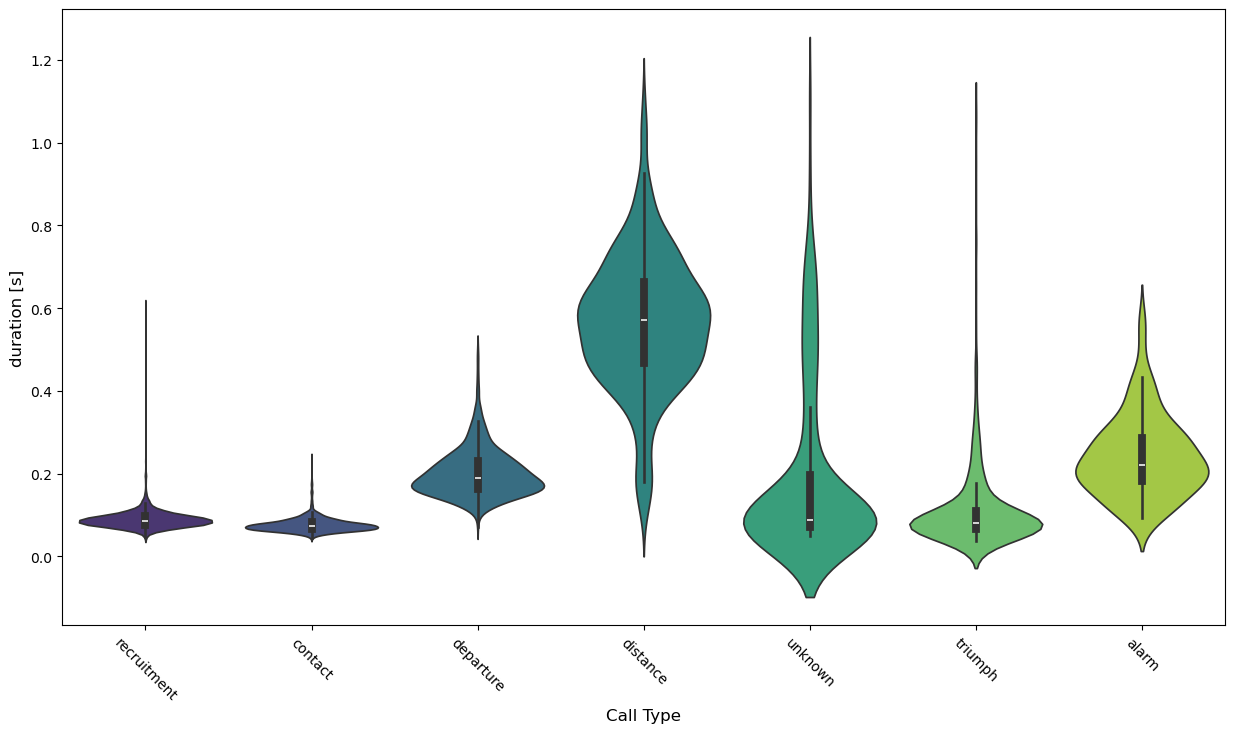

In [238]:
plt.figure(figsize=(15, 8))
sns.violinplot(
    data=calls_df,
    x="call_type",
    y="duration",
    palette="viridis",
    density_norm="width" 
)

plt.xlabel("Call Type", fontsize=12)
plt.ylabel("duration [s]", fontsize=12)
plt.xticks(rotation=-45)

##### Log scale the times for spectrograms and lfccs
Because the call durations vary substantially, we will log scale the spectrograms before padding to the longest call:

In [239]:
# take the longest call of 99.7th percentile for max length
filtered_by_percentile = calls_df.loc[calls_df["duration"] >= np.quantile(calls_df["duration"], 0.997)]
longest_call_quantile = filtered_by_percentile.loc[filtered_by_percentile["duration"].idxmin()]
max_bins_spectro = len(longest_call_quantile["spectrogram"][1])
max_bins_lfcc = len(longest_call_quantile["lfccs"][1])

longest_call_total = calls_df.loc[calls_df["duration"].idxmax()]
max_log_duration = longest_call_total["log_duration"]
max_duration_seconds = longest_call_total["duration"]
#max_bins = len(longest_call_total["spectrogram"][1])
shortest_call = calls_df.loc[calls_df["duration"].idxmin()]
min_log_duration = shortest_call["log_duration"]
min_duration_seconds = shortest_call["duration"]

# Compute log scaled target length for the waveform
calls_df["normalized_log_length"] = calls_df.apply(lambda row: (row["log_duration"]-min_log_duration)/(max_log_duration-min_log_duration), axis=1)
calls_df["log_target_duration"] = calls_df.apply(lambda row: row["normalized_log_length"]*(max_duration_seconds-min_duration_seconds)+min_duration_seconds, axis=1)

# sanity check
print(calls_df.loc[calls_df["duration"].idxmin()]["log_target_duration"], min_duration_seconds)
print(calls_df.loc[calls_df["duration"].idxmax()]["log_target_duration"], max_duration_seconds)


# resize spectrogram to match the log scaled target size, reduce to a quarter of the size to avoid too much aliasing when resizing
def _resize_spec(spectrogram, original_duration, target_duration):
    spectrogram = _to_pixel_and_cut(spectrogram)
    if spectrogram is None or len(spectrogram) == 0:
        print("Empty or None spectrogram")
        return None
    
    if np.isnan(spectrogram).any():
        print("Spectrogram contains NaN values")
        return None

    bin_size_s = original_duration / len(spectrogram[1])
    target_bins_signal = int(target_duration / bin_size_s)

    try:
        # Resample spectrogram to match the target length
        resized_spectrogram = resize(spectrogram, (spectrogram.shape[0] // 4, target_bins_signal // 4), anti_aliasing=False)
        if np.isnan(resized_spectrogram).any():
            print("NaN in resampled spectrogram")
            return None
        
    except Exception as e:
        print(f"Error during resampling: {e}")
        return None
    
    return resized_spectrogram, target_bins_signal
    
# Resample and pad spectrograms, all are downsampled to a quarter of the resolution to avoid aliasing when rescaling to log time and for more effective processing past this point
def rescale_and_pad(spectrogram, original_duration, target_duration, target_bins_total):
    resized_spec, target_bins_signal = _resize_spec(spectrogram, original_duration, target_duration)

    # padding
    total_padding = target_bins_total // 4 - target_bins_signal // 4

    # if above 99th percentile - cut outer bins
    if total_padding < 0:
        return resized_spec[:, :-np.abs(total_padding)] # cut bins on the right because reverb promotes trailing silence in clips

    left_padding = total_padding // 2
    right_padding = total_padding - left_padding
    padded_spectrogram = np.pad(resized_spec, [(0, 0), (left_padding, right_padding)], "constant", constant_values=0)
    
    if np.isnan(padded_spectrogram).any():
        print("NaN in padded spectrogram")
        return None
    
    return padded_spectrogram

# Apply transformation to each spectrogram
calls_df["log_padded_spectrogram"] = calls_df.apply(
    lambda row: rescale_and_pad(
        row["spectrogram"],
        row["duration"],
        row["log_target_duration"],
        max_bins_spectro
    ),
    axis=1
)

# Apply transformation to lfccs
calls_df["log_padded_lfccs"] = calls_df.apply(
    lambda row: rescale_and_pad(
        row["lfccs"],
        row["duration"],
        row["log_target_duration"],
        max_bins_lfcc
    ),
    axis=1
)

0.036825396825396824 0.036825396825396824
1.1085714285714285 1.1085714285714285


/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/skimage/transform/_warps.py:172: RuntimeWarning: divide by zero encountered in divide
  factors = np.divide(input_shape, output_shape)


In [240]:
calls_df[calls_df.isna().any(axis=1)]

,track_ID,clip_ID,goose_ID,call_type,waveform,sr,filepath,spectrogram,lfccs,duration,log_duration,normalized_log_length,log_target_duration,log_padded_spectrogram,log_padded_lfccs


Plot log scaled lengths and rescaled length as sanity check

[]

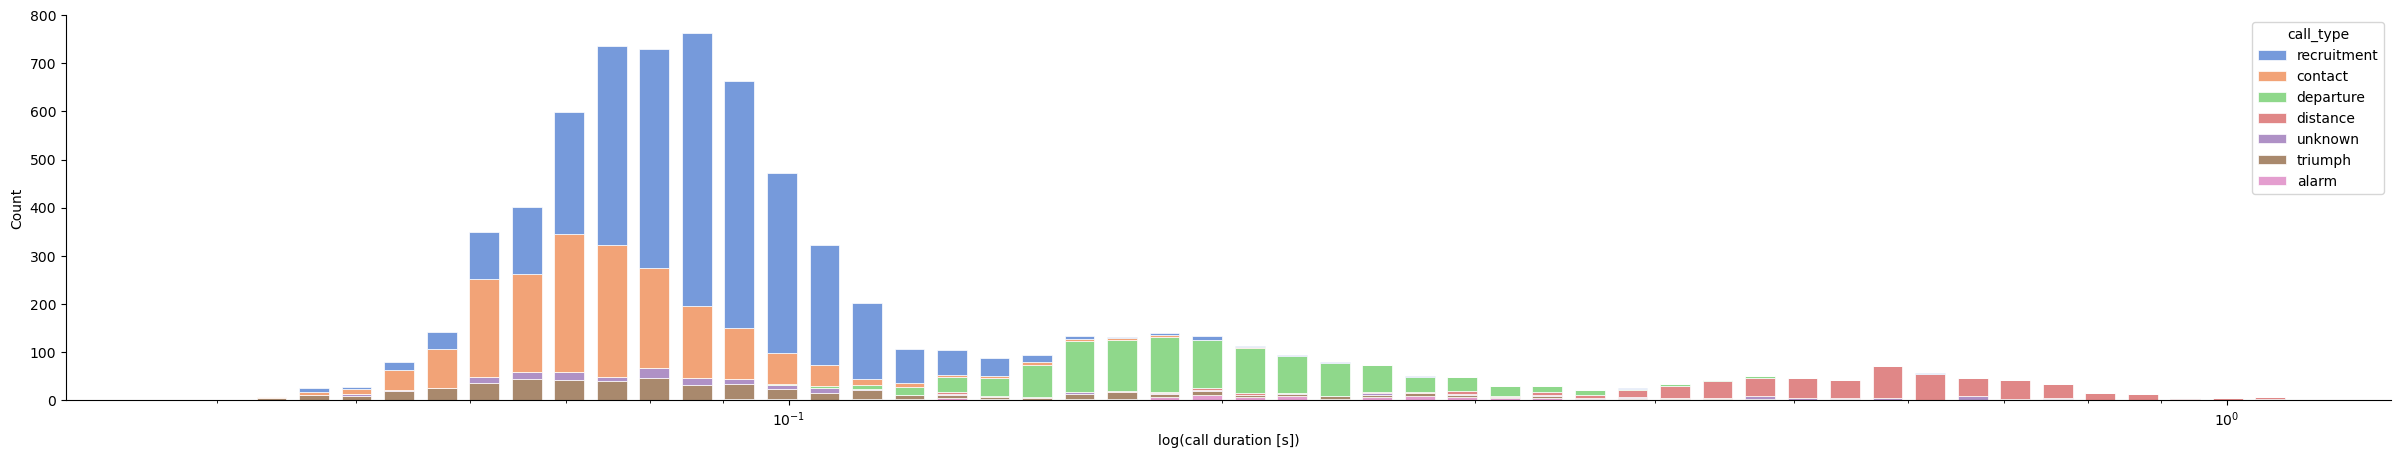

In [241]:
f, ax = plt.subplots(figsize=(30, 5))
sns.despine(f)

sns.histplot(
    calls_df,
    x="duration",
    multiple="stack",
    hue="call_type",
    palette="muted",
    edgecolor="1",
    linewidth=.5,
    shrink=.7,
    bins=50,
    log_scale=True
)
ax.set_xlabel("log(call duration [s])")
plt.plot()

[]

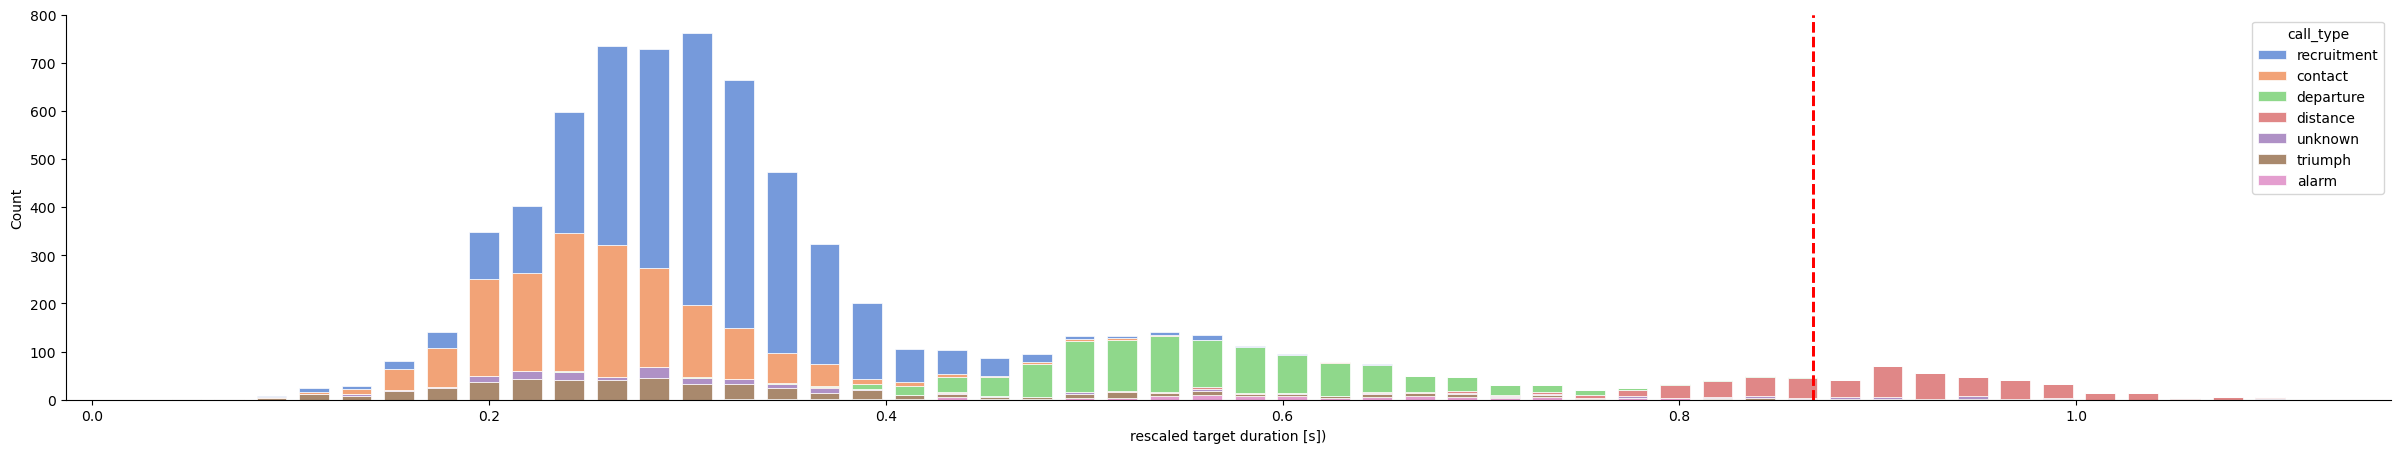

In [242]:
f, ax = plt.subplots(figsize=(30, 5))
sns.despine(f)

histplot = sns.histplot(
    calls_df,
    x="log_target_duration",
    multiple="stack",
    hue="call_type",
    palette="muted",
    edgecolor="1",
    linewidth=.5,
    shrink=.7,
    bins=50,
    ax=ax
)
ax.set_xlabel("rescaled target duration [s])")


quantile = np.quantile(calls_df["duration"], 0.997)
filtered_by_percentile = calls_df.loc[calls_df["duration"] >= quantile]
longest_call_quantile = filtered_by_percentile.loc[filtered_by_percentile["duration"].idxmin()]

ax.axvline(longest_call_quantile["duration"], color='red', linestyle='--', linewidth=2, label=f'99th Percentile: {longest_call_quantile["duration"]:.2f}')

ax.axvline(longest_call_quantile["duration"], color='red', linestyle='--', linewidth=2, label=f'99th Percentile: {longest_call_quantile["log_target_duration"]:.2f}')


plt.plot()

In [243]:
def pad_to_length(spectrogram, target_bins):
    total_padding = target_bins - len(spectrogram[1]) 
    left_padding = total_padding // 2
    right_padding = total_padding - left_padding
    return np.pad(spectrogram, [(0, 0), (left_padding, right_padding)], "constant", constant_values=0)


# Apply transformation to each waveform
calls_df["padded_spectrogram"] = calls_df.apply(
    lambda row: pad_to_length(
        _to_pixel_and_cut(row["spectrogram"]),
        len(calls_df.loc[calls_df["duration"].idxmax()]["spectrogram"][1])
    ),
    axis=1
)

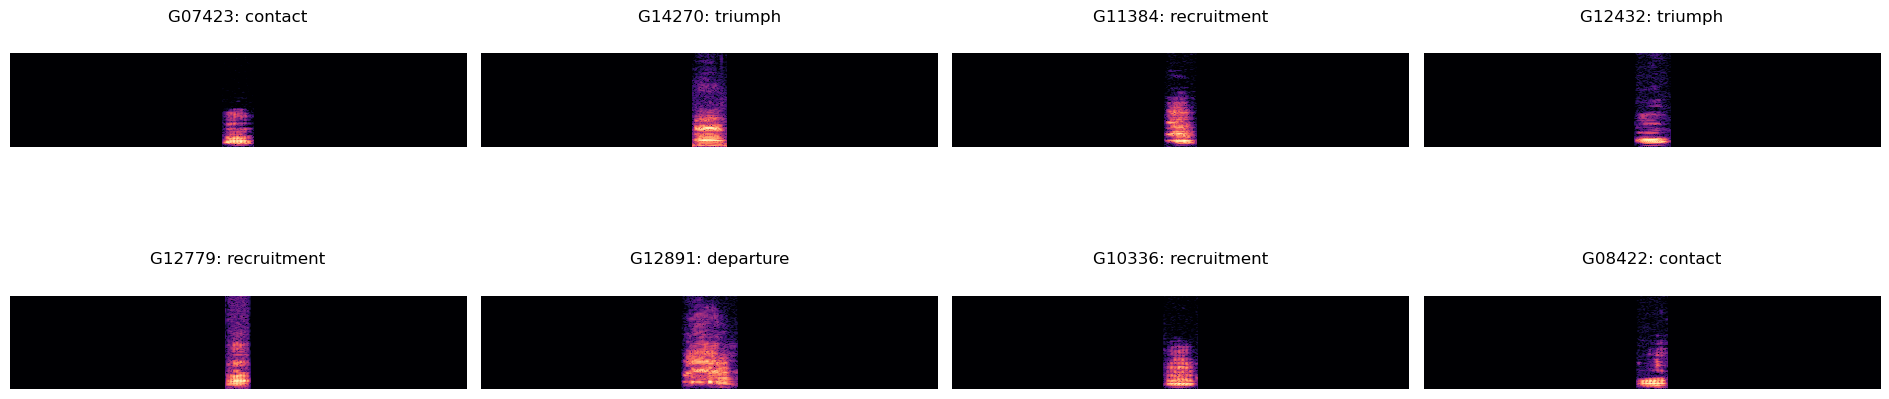

In [244]:
# plot random sample of 8 calls, linearly scaled and padded
sample_calls = calls_df.sample(n=8, random_state=43)

# plot first 8 calls
#sample_calls = calls_df.iloc[:8]

fig, axes = plt.subplots(2, 4, figsize=(19, 6))

for i, (_, vocalization) in enumerate(sample_calls.iterrows()):
  row = i // 4
  col = i % 4
  axes[row, col].matshow(vocalization["padded_spectrogram"], origin="lower", cmap="magma")
  axes[row, col].set_title(f'{vocalization["clip_ID"]}: {vocalization["call_type"]}', )
  axes[row, col].axis("off") 
    
for i in range(len(sample_calls), 8):
  row = i // 4
  col = i % 4
  axes[row, col].axis("off")

plt.tight_layout()
plt.show()

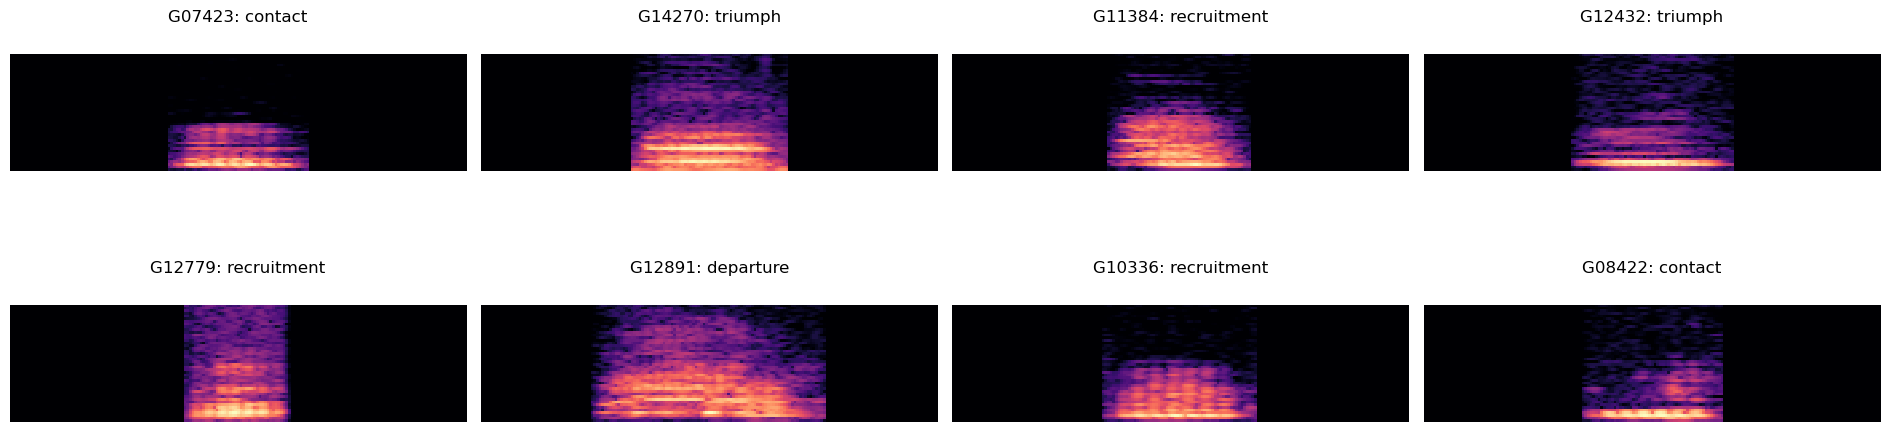

In [245]:
# plot random sample of 8 calls, log scaled and padded
sample_calls = calls_df.sample(n=8, random_state=43)

# plot first 8 calls
#sample_calls = calls_df.iloc[:8]

fig, axes = plt.subplots(2, 4, figsize=(19, 6))

for i, (_, vocalization) in enumerate(sample_calls.iterrows()):
  row = i // 4
  col = i % 4
  axes[row, col].matshow(vocalization["log_padded_spectrogram"], origin="lower", cmap="magma")
  axes[row, col].set_title(f'{vocalization["clip_ID"]}: {vocalization["call_type"]}', )
  axes[row, col].axis("off") 
    
for i in range(len(sample_calls), 8):
  row = i // 4
  col = i % 4
  axes[row, col].axis("off")

plt.tight_layout()
plt.show()

[Text(0.5, 1.0, 'GT00727_G10278_Disney_recruitment.wav')]

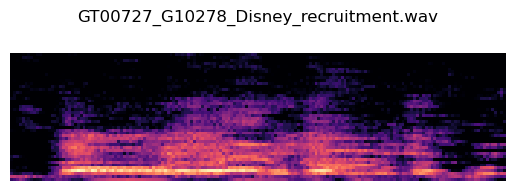

In [246]:
fig, ax = plt.subplots()
longest_call_total = calls_df.loc[calls_df["duration"].idxmax()]
ax.matshow(longest_call_total["log_padded_spectrogram"], origin="lower", cmap="magma")
ax.axis("off")
ax.set(title=clip_paths[i].split("/")[-1])

#### LFCCs

In [247]:
# # LFCCs: adapted from Heinrich Dinkel: https://gist.github.com/RicherMans/dc1b50dd8043cee5872e0b7584f6202f, gitHub profile: https://github.com/RicherMans
# def _lin_filter_bank(sr, n_fft, n_filter=128, fmin=0.0, fmax=None, dtype=np.float32):
#     # linear filter bank
#     if fmax is None:
#         fmax = float(sr) / 2
#     # Initialize the weights
#     n_filter = int(n_filter)
#     weights = np.zeros((n_filter, int(1 + n_fft // 2)), dtype=dtype)

#     # Center freqs of each FFT bin
#     fftfreqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

#     # 'Center freqs' of liner bands - uniformly spaced between limits
#     linear_f = np.linspace(fmin, fmax, n_filter + 2)

#     fdiff = np.diff(linear_f)
#     ramps = np.subtract.outer(linear_f, fftfreqs)

#     for i in range(n_filter):
#         # lower and upper slopes for all bins
#         lower = -ramps[i] / fdiff[i]
#         upper = ramps[i + 2] / fdiff[i + 1]

#         # .. then intersect them with each other and zero
#         weights[i] = np.maximum(0, np.minimum(lower, upper))

#     return weights

# def to_lfccs(waveform, sr, n_fft, dct_type=2, norm='ortho', plot=False, **kwargs):
#     n_lfcc = len(waveform) // 200 # choose number of coefficients relative to call length
#     spectrogram = np.abs(librosa.stft(waveform, n_fft=n_fft, hop_length=(n_fft//hop_overlap)))**2
#     filter = _lin_filter_bank(sr=sr, n_fft=n_fft, n_filter=n_lfcc*5, **kwargs)
#     filtered_S = np.dot(filter, spectrogram)
#     filtered_S = librosa.power_to_db(filtered_S, ref=np.max)
#     lfccs = scipy.fftpack.dct(filtered_S, axis=0, type=dct_type, norm=norm)[:n_lfcc]
#     if plot:
#         fig, ax = plt.subplots()
#         ax.matshow(_to_pixel_and_cut(lfccs), origin="lower", cmap="magma")
#         ax.axis("off")
#         ax.set(title=clip_paths[i].split("/")[-1])
#     return lfccs

In [248]:
# # Apply transformation to lfccs
# calls_df["log_padded_lfccs"] = calls_df.apply(
#     lambda row: to_lfccs(
#         row["log_padded_spectrogram"]
#     ),
#     axis=1
# )

#### Extract audio features using **Praat/Parselmouth**: 


In [249]:
#TODO: several NA returns - check why and fix or find better solution

**Temporal features (retrieved from temporal envelope in amlitude pressure):**
- Mean T: temporal centroid
- Std T: temporal duration
- Skew T: temporal skewness (asymmery)
- Kurt T: temporal kurtosis (peakedness)
- Ent T: temporal entropy (overall variability)

**Spectral features (from spectral envelope in power/pressure square):**
- Mean S: spectral centroid
- Std S: spectral duration
- Skew S: spectral skewness (asymmery)
- Kurt S: spectral kurtosis (peakedness)
- Ent S: spectral entropy (overall variability)
- Q1, Q2, G3: q-th quartile of power spectrum

**From time-varying fundamental frequency:**
- Mean F0: mean fundamental frequency
- Sal: mean pitch saliency (ratio)
- Max F0: mean fundamental
- Min F0: minimum fundamental
- CV F0: coefficient of variation (measure of frequency modulation)

In [250]:
f0_floor = 350 # leads to window of ~0.002 seconds
f0_ceil = 2000
vtl_m = 0.378 # Würdinger 1970, taken from Anser fabilis, because most similar overall body size to Anser anser

In [251]:
def plot_feature_spectrogram(snd, pitch=None, intensity=None, formant=None, dynamic_range=70):
    spectrogram = snd.to_spectrogram(window_length=0.01, maximum_frequency=10000, time_step=0.0005, window_shape=parselmouth.SpectralAnalysisWindowShape.HANNING)

    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    sg_db = 10 * np.log10(spectrogram.values)
    plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='afmhot')
    plt.ylim([spectrogram.ymin, spectrogram.ymax])
    plt.xlabel("time [s]")
    plt.ylabel("frequency [Hz]")

    if pitch:
        plt.twinx()
        plt.xlim([snd.xmin, snd.xmax])
        _plot_pitch(pitch, ylim=[spectrogram.ymin, spectrogram.ymax])
    
    if formant:
        plt.twinx()
        plt.xlim([snd.xmin, snd.xmax])
        _plot_formant(formant, snd.xmin, snd.xmax, ylim=[spectrogram.ymin, spectrogram.ymax])
    
    plt.show()

    if intensity:
        plt.twinx()
        plt.xlim([snd.xmin, snd.xmax])
        _plot_intensity(intensity)
    
    plt.show()

    
def _plot_pitch(pitch, ylim=[]):
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=5, color='w')
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=2)
    plt.grid(False)
    if ylim==[]:
        plt.ylim(0, pitch.ceiling)
    else: 
        plt.ylim(ylim)
    plt.ylabel("fundamental frequency [Hz]")

def _plot_intensity(intensity):
    intensity_values = intensity.values[0]
    intensity_values[intensity_values==0] = np.nan
    plt.plot(intensity.xs(), intensity_values, 'o', markersize=2)
    plt.grid(False)
    plt.ylim(0, np.max(intensity_values))
    plt.ylabel("intensity [dB SPL]")

def _plot_formant(formant, xmin, xmax, ylim=[]):
    plt.plot(np.linspace(xmin, xmax, len(formant)), formant, 'o', markersize=2)
    plt.grid(False)
    if ylim==[]:
        plt.ylim(0, np.max(formant))
    else:
        plt.ylim(ylim)

In [252]:
# fundamental
"""
- ~~ Mean F0: mean fundamental frequency
- ~~ Sal: mean pitch saliency (ratio) - hnr instead
- ~~ Max F0: maximum fundamental
- ~~ Min F0: minimum fundamental
- ~~ CV F0: coefficient of variation (measure of frequency modulation) -std instead
"""
def calculate_f0_related_features(snd, f0_floor, f0_ceil):
    # https://parselmouth.readthedocs.io/en/stable/api_reference.html#parselmouth.Sound.to_pitch
    pitch = parselmouth.praat.call(snd, "To Pitch", 0, f0_floor, f0_ceil)
    f0mean = parselmouth.praat.call(pitch, "Get mean", 0, 0, "Hertz")/1000 # to kHz
    f0min = parselmouth.praat.call(pitch, "Get minimum", 0, 0, "Hertz", "parabolic")/1000 # to kHz
    f0max = parselmouth.praat.call(pitch, "Get maximum", 0, 0, "Hertz", "parabolic")/1000 # to kHz
    f0range = (f0max - f0min) / 1000 # to kHz
    f0std_dev = parselmouth.praat.call(pitch, "Get standard deviation", 0, 0, "Hertz")/1000 # to kHz
    mean_slope = pitch.get_mean_absolute_slope()/1000 # to kHz/s
    f0_q1 = parselmouth.praat.call(pitch, "Get quantile", 0.0, 0.0, 0.25, "Hertz")/1000 # to kHz
    f0_q2 = parselmouth.praat.call(pitch, "Get quantile", 0.0, 0.0, 0.5, "Hertz")/1000 # to kHz
    f0_q3 = parselmouth.praat.call(pitch, "Get quantile", 0.0, 0.0, 0.75, "Hertz")/1000 # to kHz
    return f0mean, f0min, f0max, f0range, f0std_dev, mean_slope, pitch, f0_q1, f0_q2, f0_q3

# spectral
def calculate_hnr(snd):
    harmonicity = snd.to_harmonicity()
    return harmonicity.values[harmonicity.values != -200].mean()

def calculate_spectral_features(snd):
    spectrum = snd.to_spectrum()
    centr_s = spectrum.get_center_of_gravity()/1000 # to kHz
    skew_s = spectrum.get_skewness()
    kurt_s = spectrum.get_kurtosis()
    std_s = spectrum.get_standard_deviation()/1000 # to kHz
    return centr_s, skew_s, kurt_s, std_s
"""
- -- Mean S: spectral centroid
- -- Std S: spectral std
- -- Skew S: spectral skewness (asymmery)
- -- Kurt S: spectral kurtosis (peakedness)
- Ent S: spectral entropy (overall variability)
- -- Q1, Q2, Q3: q-th quartile of power spectrum
"""

# temporal
def calculate_temporal_features(snd):
    intensity = snd.to_intensity(minimum_pitch=350)
    centr_t = intensity.centre_time
    std_t = np.std(intensity.values[0])
    skew_t = skew(intensity.values[0])
    kurt_t = kurtosis(intensity.values[0])
    return centr_t, skew_t, kurt_t, std_t, intensity

"""
- Cent T: temporal centroid
- Std T: temporal std
- Skew T: temporal skewness (asymmery)
- Kurt T: temporal kurtosis (peakedness)
"""

# formants
def _estimate_formant_ceiling(vtl_m):
    return 15*(340/(4*vtl_m))*1.1 # lower formants are expected to be below f0

def calculate_first_formant(snd):
    # adapted from https://github.com/drfeinberg/PraatScripts/blob/master/Measure%20Pitch%2C%20HNR%2C%20Jitter%2C%20Shimmer%2C%20and%20Formants.ipynb
    formant_ceiling = _estimate_formant_ceiling(vtl_m)
    pointProcess = parselmouth.praat.call(snd, "To PointProcess (periodic, cc)", f0_floor, f0_ceil)
    formant = parselmouth.praat.call(snd, "To Formant (burg)", 0.0, 1, formant_ceiling, 0.001, 100)
    numPoints = parselmouth.praat.call(pointProcess, "Get number of points")

    f1_list = []
    # Measure formant only at glottal pulses
    for point in range(0, numPoints):
        point += 1
        t = parselmouth.praat.call(pointProcess, "Get time from index", point)
        f1 = parselmouth.praat.call(formant, "Get value at time", 1, t, 'Hertz', 'Linear')
        f1_list.append(f1)
    
    f1_list = [f1 for f1 in f1_list if str(f1) != 'nan']
    
    # calculate mean formant across pulses
    f1_mean = np.mean(f1_list)/1000 # to kHz
    return f1_mean, f1_list


In [253]:
def calc_features(filepath, plot_spectrogram=False):
    snd = parselmouth.Sound(filepath)
    f0mean, f0min, f0max, f0range, f0std_dev, mean_slope, pitch, f0_q1, f0_q2, f0_q3 = calculate_f0_related_features(snd, f0_floor, f0_ceil)
    hnr = calculate_hnr(snd)
    # spectral
    centr_s, skew_s, kurt_s, std_s = calculate_spectral_features(snd)
    # temporal
    centr_t, skew_t, kurt_t, std_t, intensity = calculate_temporal_features(snd)
    # formants
    formant, formant_list = calculate_first_formant(snd)
    if plot_spectrogram:
        plot_feature_spectrogram(snd, pitch, intensity, formant_list)
    return pd.DataFrame([[filepath, f0mean, f0range, f0min, f0max, f0std_dev, mean_slope, f0_q1, f0_q2, f0_q3, hnr, centr_s, skew_s, kurt_s, std_s, centr_t, skew_t, kurt_t, std_t, formant]], columns = ["filepath", "f0mean", "f0range", "f0min", "f0max", "f0std_dev", "mean_slope", "f0_q1", "f0_q2", "f0_q3", "hnr", "centr_s", "skew_s", "kurt_s", "std_s", "centr_t", "skew_t", "kurt_t", "std_t", "avg_f_form1"])

1.35500389326616


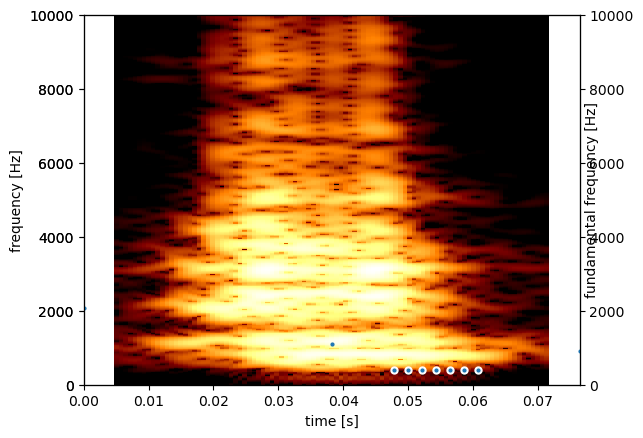

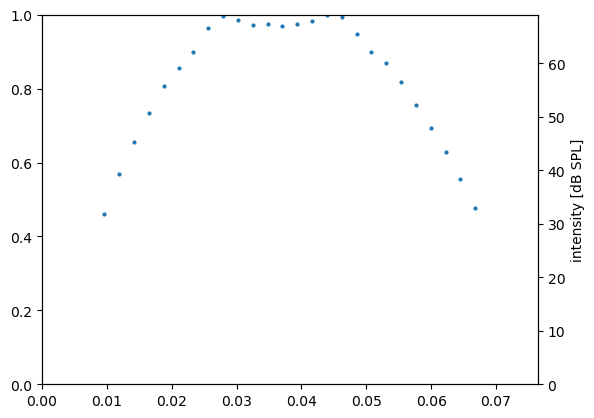

,filepath,f0mean,f0range,f0min,f0max,f0std_dev,mean_slope,f0_q1,f0_q2,f0_q3,hnr,centr_s,skew_s,kurt_s,std_s,centr_t,skew_t,kurt_t,std_t,avg_f_form1
0,/Users/lenagies/Desktop/Master/Thesis/geese/da...,0.396184,0.000014,0.38857,0.402706,0.004758,2.244531,0.39284,0.397194,0.399288,1.51943,2.255544,0.254707,0.382637,1.056549,0.03822,-0.762984,-0.742269,11.85066,1.355004


In [254]:
features_df = calc_features(calls_df.iloc[1210]["filepath"], plot_spectrogram=True)
features_df.head()

In [255]:
features_df = pd.DataFrame()

for _, row in calls_df.iterrows():
    temp_df = calc_features(row["filepath"])
    features_df = pd.concat([features_df, temp_df], ignore_index=True)

features_df.head()

0.9297327004587149
1.525552049276808
1.4726516587454765
2.4923486107405814
1.0327020336203336
1.4897935840027403
1.4305418100836884
1.0921445259636446
1.6222773503803871
nan
1.5935364730833774
1.8163874906082862
1.2648594367560648


/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1.18956189610813
nan
1.2694327086226362
1.0916318935252114
1.360463807982978
2.86039031590831
1.9273584794306071
nan
1.3919382950825132
1.9993408341148184
1.1552606451727867
1.4087009928110488
1.4602422610800725
2.160265067571234
1.8499192489436416
1.8850384405771292
1.5555580193317833
1.0243282021666775
1.7559306998747775
1.243683728348009
1.1031221987581854
1.2067322314118598
1.4365874669950471
1.8698531343678733
1.7480942419854437
1.6896065937685774
nan
1.7223286518937402
1.5657299509077591
1.2878541274338322
1.458826197723719
0.9624931825529227
2.459682946484835
2.5175216068859845
1.6928292499938007
1.9870927485913161
1.3626744224774867
1.340374780689236
1.8511302906624636
1.2019904361199656
1.7860782922395901
1.201510382307072
1.3579895944408897
1.485344623340353
2.626292825461273
nan
1.0653725562738865
1.3483174001909453
nan
1.9226954003210959
1.0309170764380633
0.9604544885437784
1.5505118290282007
1.7542777311246855
1.5849815669214382
nan
2.5683606735661124
1.0978675385622725
2

,filepath,f0mean,f0range,f0min,f0max,f0std_dev,mean_slope,f0_q1,f0_q2,f0_q3,hnr,centr_s,skew_s,kurt_s,std_s,centr_t,skew_t,kurt_t,std_t,avg_f_form1
0,/Users/lenagies/Desktop/Master/Thesis/geese/da...,0.751705,0.000189,0.623827,0.813156,0.032851,12.785791,0.740688,0.756895,0.768470,8.516782,0.785028,17.898900,1424.843732,0.172809,0.060397,-1.169735,0.208856,10.638023,0.929733
1,/Users/lenagies/Desktop/Master/Thesis/geese/da...,1.106434,0.000068,1.071432,1.138934,0.015909,6.587618,1.098634,1.106392,1.115408,2.253009,1.341586,2.889929,10.891916,0.744212,0.056848,-0.869065,-0.289031,10.923155,1.525552
2,/Users/lenagies/Desktop/Master/Thesis/geese/da...,0.677272,0.000083,0.643456,0.726281,0.025184,9.420940,0.659936,0.676128,0.683780,3.817782,1.300958,2.299268,9.314555,0.645904,0.054127,-1.244654,0.553326,9.605882,1.472652
3,/Users/lenagies/Desktop/Master/Thesis/geese/da...,1.356471,0.000413,1.103446,1.516809,0.149637,16.295504,1.191127,1.436120,1.488335,4.827432,2.575523,1.436128,4.415606,1.358531,0.089717,-1.362490,1.175284,11.304043,2.492349
4,/Users/lenagies/Desktop/Master/Thesis/geese/da...,0.747127,0.000117,0.693678,0.810182,0.029453,12.685318,0.719614,0.746257,0.766221,6.702358,0.868424,4.701380,70.855274,0.278164,0.053503,-1.264512,0.456110,10.050527,1.032702


In [256]:
calls_df = pd.merge(calls_df, features_df, how='left', on='filepath')

In [257]:
calls_df.head()

,track_ID,clip_ID,goose_ID,call_type,waveform,sr,filepath,spectrogram,lfccs,duration,...,hnr,centr_s,skew_s,kurt_s,std_s,centr_t,skew_t,kurt_t,std_t,avg_f_form1
0,GT00780,G11666,Lando,recruitment,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[-80.0, -80.0, -80.0, -74.5504, -68.28476, -6...","[[-885.8393, -862.04083, -834.7281, -813.42786...",0.105397,...,8.516782,0.785028,17.898900,1424.843732,0.172809,0.060397,-1.169735,0.208856,10.638023,0.929733
1,GT00772,G11510,Burglar,recruitment,"[0.0016997167, 0.0056657223, 0.007082153, 0.00...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[-58.680573, -59.456085, -62.740047, -69.3654...","[[-830.7733, -819.18225, -810.61523, -803.8673...",0.104807,...,2.253009,1.341586,2.889929,10.891916,0.744212,0.056848,-0.869065,-0.289031,10.923155,1.525552
2,GT00795,G11994,EinStein,contact,"[-0.0010507881, -0.0017513135, -0.0017513135, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...","[[-841.1946, -834.2097, -831.37274, -829.4686,...",0.104127,...,3.817782,1.300958,2.299268,9.314555,0.645904,0.054127,-1.244654,0.553326,9.605882,1.472652
3,GT00447,G04128,BruceSpringsteen,departure,"[-0.00035599858, -0.00071199716, -0.0007119971...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...","[[-863.0115, -852.62213, -838.2617, -811.85333...",0.162925,...,4.827432,2.575523,1.436128,4.415606,1.358531,0.089717,-1.362490,1.175284,11.304043,2.492349
4,GT00775,G11567,Anthony,recruitment,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[-72.21927, -68.95039, -69.03602, -73.3953, -...","[[-869.5825, -851.7381, -835.519, -821.2745, -...",0.093968,...,6.702358,0.868424,4.701380,70.855274,0.278164,0.053503,-1.264512,0.456110,10.050527,1.032702


In [258]:
len(calls_df[calls_df["avg_f_form1"].isna()])

832

In [259]:
calls_df[calls_df.isna().any(axis=1)]

,track_ID,clip_ID,goose_ID,call_type,waveform,sr,filepath,spectrogram,lfccs,duration,...,hnr,centr_s,skew_s,kurt_s,std_s,centr_t,skew_t,kurt_t,std_t,avg_f_form1
9,GT00157,G00695,Lukka,departure,"[0.0054388135, 0.004697157, 0.0034610631, 0.00...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...","[[-839.10406, -831.5061, -830.16266, -829.2651...",0.321270,...,4.165544,1.780453,2.820014,10.663184,1.155042,0.218265,-3.990843,15.904626,69.956004,NaN
14,GT00570,G06457,Batate,contact,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[-66.272736, -67.54608, -71.41384, -80.0, -63...","[[-874.3027, -860.61, -847.9724, -839.0222, -8...",0.067302,...,2.547630,0.840684,3.382918,58.926607,0.259464,0.035136,-1.128598,0.375292,7.638876,NaN
20,GT00997,G14404,Jurek,triumph,"[-0.012969468, -0.014050256, -0.012158876, -0....",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[-37.425983, -37.38008, -39.00888, -29.999996...","[[-618.94446, -595.50494, -584.20197, -564.753...",0.052358,...,-0.321438,2.570065,0.810968,9.258225,1.242590,0.026179,-1.208455,0.438088,4.529283,NaN
39,GT00973,G12118,Lausbursch,contact,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[-49.32687, -44.536095, -41.655212, -41.19981...","[[-604.59875, -575.2202, -559.91705, -555.9117...",0.086984,...,1.246254,1.039416,6.904147,99.120693,0.792038,0.043492,-0.180858,-1.451995,7.422567,NaN
58,GT00735,G10541,Babaco,contact,"[-0.002988048, -0.00249004, -0.001992032, -0.0...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[-65.10849, -65.51999, -66.391235, -69.017845...","[[-830.7978, -817.40625, -808.1288, -799.67114...",0.069841,...,1.815815,1.606730,0.807478,0.044218,0.957440,0.040363,-0.690369,-0.869540,10.300219,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7475,GT00599,G07283,Jurek,contact,"[0.0018294913, 0.0018294913, 0.0016465422, 0.0...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[-80.0, -80.0, -78.55889, -80.0, -80.0, -80.0...","[[-862.87396, -850.0125, -840.23444, -826.4963...",0.063447,...,0.593292,1.295587,1.858300,4.878585,0.671719,0.034898,-1.183039,0.973352,7.929436,NaN
7491,GT00567,G06382,Leia,recruitment,"[-0.0015936255, -0.00079681276, -0.00079681276...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[-71.60271, -70.77863, -72.44713, -72.25587, ...","[[-869.5383, -860.3056, -853.37897, -845.6581,...",0.134467,...,4.494343,1.102270,2.918519,60.275238,0.242497,0.071043,-1.738945,2.068999,9.889794,NaN
7492,GT00712,G09959,Natalie,recruitment,"[0.0026126713, 0.0032658393, 0.0026126713, 0.0...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[-75.979004, -71.18407, -72.95383, -80.0, -68...","[[-837.0581, -823.13635, -811.0229, -798.61554...",0.100317,...,2.643577,1.444309,2.452932,5.923325,0.925793,0.059592,-1.242429,0.233788,13.539251,NaN
7494,GT00991,G14289,unknown,distance,"[-0.04993097, -0.026461113, -0.0046019326, 0.0...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[-30.229954, -30.115656, -31.85024, -34.37258...","[[-532.6851, -530.52997, -545.4788, -571.09186...",0.179002,...,4.566878,1.987066,1.955654,7.279995,1.343792,0.089501,-2.198182,4.181746,4.321137,NaN


##### Display examples and export csv

/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_6536/904384471.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  example_calls = calls_df.groupby('call_type', group_keys=False).apply(subsample_group)


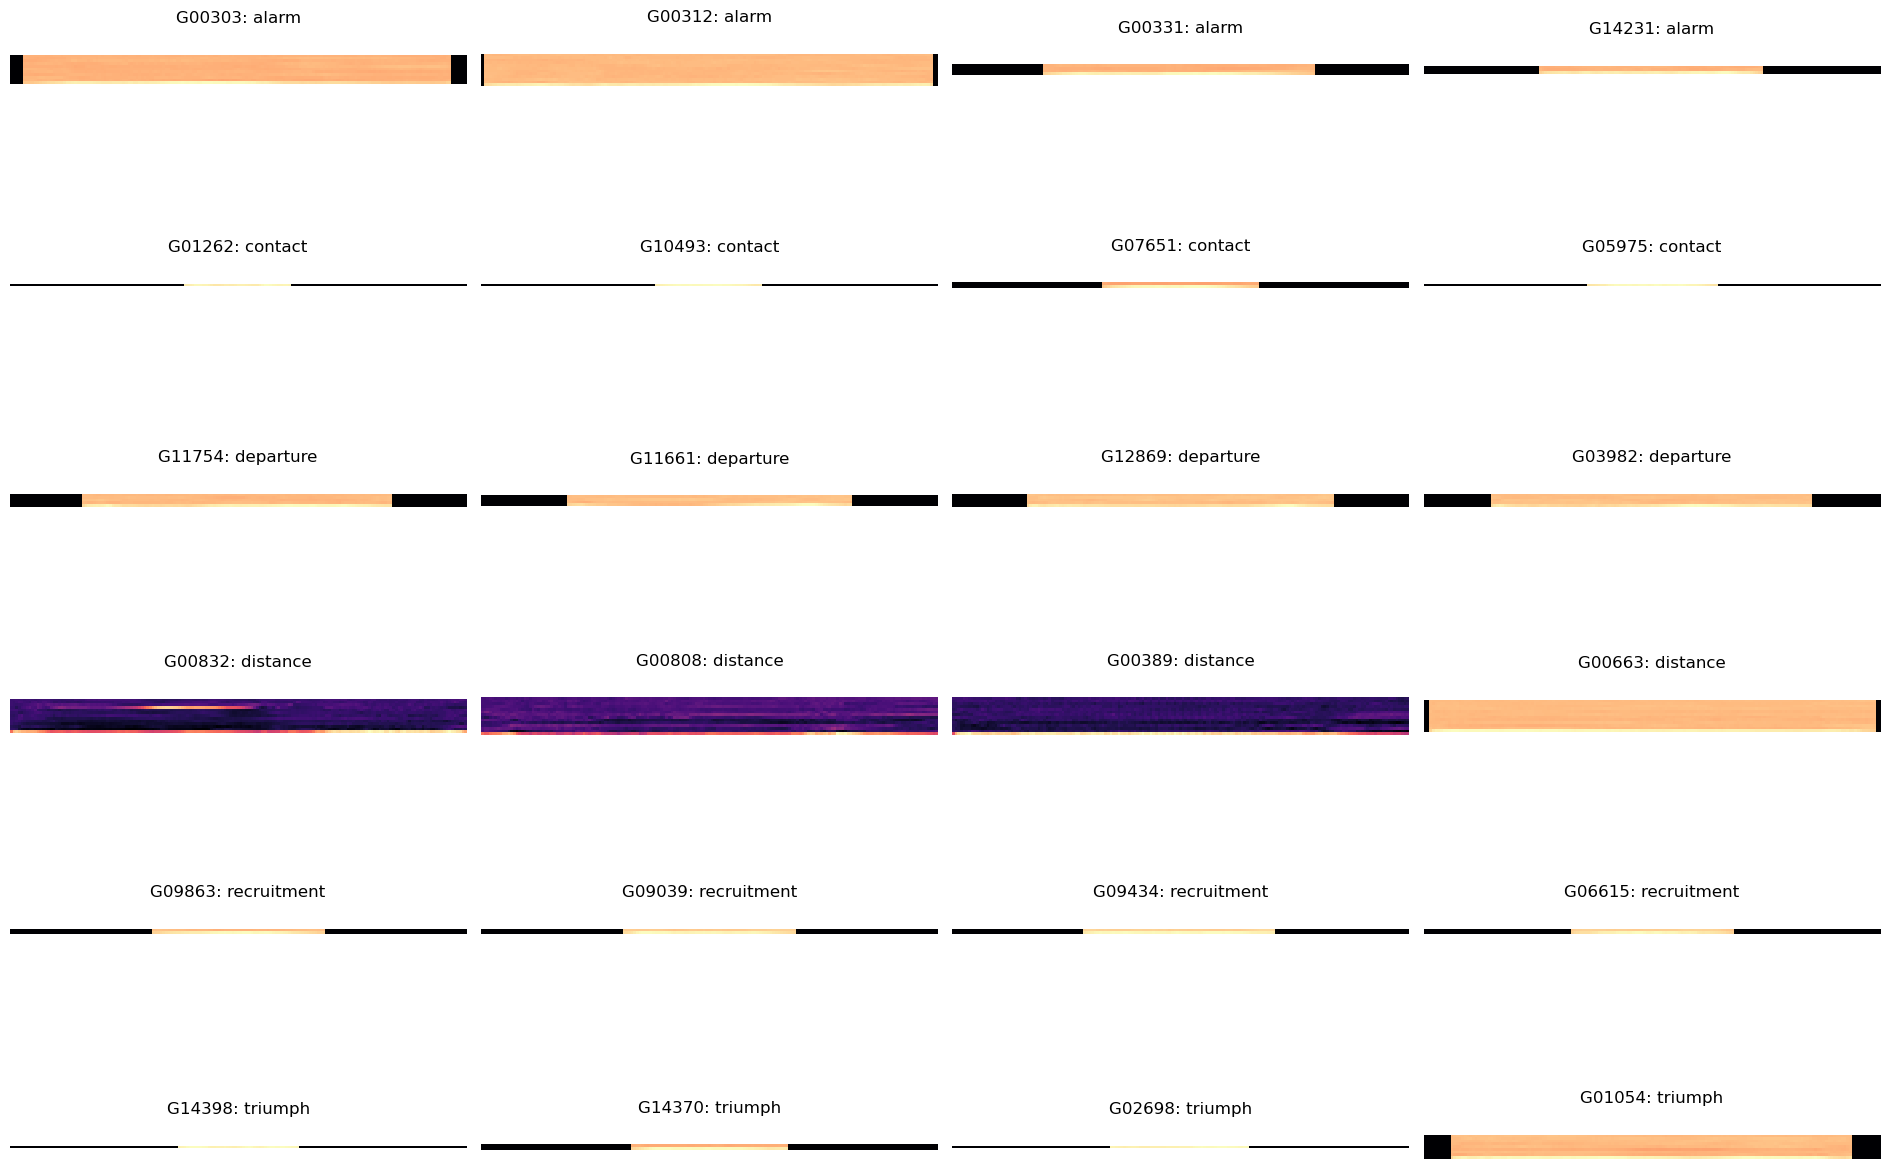

In [260]:
subset_size = 4

subsample_sizes = {
  'recruitment': subset_size,
  'contact': subset_size,
  'departure': subset_size,
  'triumph': subset_size,
  'alarm': subset_size,
  'distance': subset_size,
  #'unknown': subset_size,
}

# Randomly subsample per call type
def subsample_group(group):
  call_type = group.name  # Group name corresponds to call type
  if call_type in subsample_sizes:
    return group.sample(n=subsample_sizes[call_type]) #, random_state=44

# Group by type and apply subsampling
example_calls = calls_df.groupby('call_type', group_keys=False).apply(subsample_group)

fig, axes = plt.subplots(6, 4, figsize = (19, 14))

for i, (_, vocalization) in enumerate(example_calls.iterrows()):
  row = i // 4
  col = i % 4
  axes[row, col].matshow(vocalization["log_padded_lfccs"], origin="lower", cmap="magma")
  axes[row, col].set_title(f'{vocalization["clip_ID"]}: {vocalization["call_type"]}', )
  axes[row, col].axis("off") 
    
for i in range(len(sample_calls), 24):
  row = i // 4
  col = i % 4
  axes[row, col].axis("off")

plt.tight_layout()
plt.show()

In [261]:
# # export all spectrograms listed per type to pngs
# sorted_df = calls_df.sort_values(by=["call_type", "track_ID", "clip_ID"])

# for idx in range(0, len(sorted_df), 28):
#   fig, axes = plt.subplots(7, 4, figsize = (19, 14))
#   for i, vocalization in sorted_df.iloc[idx:idx+28].reset_index().iterrows():
#     row = i // 4
#     col = i % 4
#     axes[row, col].matshow(vocalization["log_padded_spectrogram"], origin="lower", cmap="magma")
#     axes[row, col].set_title(f'{vocalization["track_ID"]} - {vocalization["clip_ID"]}: {vocalization["call_type"]}')
#     axes[row, col].axis("off") 
      
#   for i in range(len(sample_calls), 28):
#     row = i // 4
#     col = i % 4
#     axes[row, col].axis("off")

#   plt.tight_layout()
#   #plt.show()
#   fig.savefig(f'spectrograms/{sorted_df.iloc[idx]["track_ID"]}_{sorted_df.iloc[idx+28]["track_ID"]}.png')

In [262]:
calls_df["log_padded_spectrogram"] = calls_df["log_padded_spectrogram"].apply(lambda x: json.dumps(x.tolist()))

In [263]:
calls_df.drop(columns=["padded_spectrogram", "spectrogram", "log_duration"]).to_csv('features_and_spectrograms.csv', index=False)